In [1]:
import os
from tqdm import tqdm
from PIL import Image
from PIL import ImageDraw
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
import pandas as pd
import torch
import torchvision
import torchvision.transforms.functional as TF

In [2]:
annot = pd.read_csv('C:\\DATA\\SEA TURTLE\\labels.csv', header = None)
annot.head()

,0,1,2,3,4,5,6,7
0,Turtle,639,241,347,259,Image_1.jpg,1000,1000
1,Turtle,632,183,481,441,Image_2.jpg,2000,1000
2,Turtle,378,429,156,119,Image_3.jpg,1200,800
3,Turtle,1368,431,519,377,Image_4.jpg,2500,1667
4,Turtle,1044,1498,1088,772,Image_5.jpg,4613,2968


In [3]:
annot = annot.drop([6, 7], axis = 1)
annot = annot.rename(columns = {0: 'label', 1: 'x', 2: 'y', 3: 'w', 4: 'h', 5: 'image'})
annot['label_one'] = 1
annot['xmax'] = annot['x'] + annot['w']
annot['ymax'] = annot['y'] + annot['h']

In [4]:
annot.head()

,label,x,y,w,h,image,label_one,xmax,ymax
0,Turtle,639,241,347,259,Image_1.jpg,1,986,500
1,Turtle,632,183,481,441,Image_2.jpg,1,1113,624
2,Turtle,378,429,156,119,Image_3.jpg,1,534,548
3,Turtle,1368,431,519,377,Image_4.jpg,1,1887,808
4,Turtle,1044,1498,1088,772,Image_5.jpg,1,2132,2270


In [5]:
def Show_Img_Label(img, label, thickness = 2):
    x, y, xmax, ymax = label[0]
    img = img.permute(1, 2, 0).numpy()
    plt.imshow(img)
    plt.gca().add_patch(Rectangle((x, y), xmax-x, ymax-y, linewidth = thickness, edgecolor = 'r', facecolor = 'none'))

In [6]:
class SeaTurtleDataset(torch.utils.data.Dataset):
    def __init__(self, img_dir, df):
        self.img_dir = img_dir
        self.df = df
        self.images = list(sorted(os.listdir(os.path.join(self.img_dir))))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.images[idx])
        img = Image.open(img_path).convert('RGB')
        row = self.df[self.df['image'] == self.images[idx]]
        boxes = row[['x', 'y', 'xmax', 'ymax']].values
        boxes = torch.as_tensor(boxes, dtype = torch.float32)
        if boxes.shape[0] > 1:
            labels = torch.ones(boxes.shape[0], dtype = torch.int64)
        else:
            labels = torch.ones(1, dtype = torch.int64)
        #labels = row[['label_one']].values
        #labels = torch.ones(label[0][0], dtype = torch.int64)
        img = TF.to_tensor(img)
        targets = {}
        targets['boxes'] = boxes
        targets['labels'] = labels
        return img, targets

In [7]:
data = SeaTurtleDataset('C:\\DATA\\SEA TURTLE\\images', annot)

In [8]:
data[211]

(tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0118, 0.0118, 0.0078,  ..., 0.0431, 0.0431, 0.0510],
          [0.0196, 0.0157, 0.0157,  ..., 0.0431, 0.0510, 0.0588],
          [0.0196, 0.0157, 0.0118,  ..., 0.0549, 0.0549, 0.0627]],
 
         [[0.5333, 0.5333, 0.5333,  ..., 0.4431, 0.4431, 0.4431],
          [0.5333, 0.5333, 0.5333,  ..., 0.4431, 0.4431, 0.4431],
          [0.5333, 0.5333, 0.5333,  ..., 0.4431, 0.4431, 0.4431],
          ...,
          [0.0980, 0.0980, 0.0941,  ..., 0.0980, 0.1176, 0.1333],
          [0.1137, 0.1098, 0.1098,  ..., 0.0980, 0.1255, 0.1412],
          [0.1255, 0.1216, 0.1176,  ..., 0.0980, 0.1216, 0.1451]],
 
         [[0.8235, 0.8235, 0.8235,  ..., 0.7608, 0.7608, 0.7608],
          [0.8235, 0.8235, 0.8235,  ..., 0.7608, 0.7608, 0.7608],
          [0.8235, 0.8235, 0.8235,  ...,

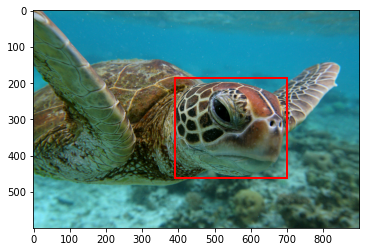

In [9]:
Show_Img_Label(data[10][0], data[10][1]['boxes'])

In [10]:
len(data)

2000

In [11]:
train_data_split, val_data_split = torch.utils.data.random_split(data, [1000, 1000])

In [12]:
# val_size = 0.1
# val_inds = np.random.choice(len(data), size = int(val_size * len(data)), replace = False)
# train_data_split = torch.utils.data.Subset(data, [i for i in range(len(data)) if i not in val_inds])
# val_data_split = torch.utils.data.Subset(data, val_inds)
# print(len(train_data_split), len(val_data_split))

1800 200


In [12]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [13]:
train_dataloader = torch.utils.data.DataLoader(train_data_split, batch_size = 1, shuffle = False, collate_fn = collate_fn)
val_dataloader = torch.utils.data.DataLoader(val_data_split, batch_size = 1, shuffle = False, collate_fn = collate_fn)

In [23]:
# images, targets = next(iter(train_dataloader))

In [14]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [15]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained = True)

In [16]:
num_classes = 2
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [18]:
model = model.to(device)

In [18]:
# from catalyst import metrics
# metric = metrics.IOUMetric()

In [19]:
optimizer = torch.optim.Adam(model.parameters(), amsgrad = True, lr = 0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [20]:
def train_model(model, train_loader, optimizer, n_epochs):
    
    train_loss = []
    
    for epoch in range(n_epochs):
        ep_train_loss = []
        
        model.train()
        
        for images, targets in tqdm(train_loader):
            optimizer.zero_grad()
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            ep_train_loss.append(losses.item())
            losses.backward()
            optimizer.step()
                
        print(f'Epoch {epoch + 1} of {n_epochs}')       
        
        train_loss.append(np.mean(ep_train_loss))
        
        print(f"\t train_loss: {train_loss[-1]:.6f}")
        
    return train_loss